# Processing sample S2 with the standard scanpy pipeline

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

## Preprocessing
### Read data

In [2]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1326 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [3]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1326 × 5572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [4]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.947
Zero inflation of aggregated data: 0.856


## Attach transcription units

In [5]:
tu = pd.read_csv("../../data/MOBA_scRNAseq/PAO1 gene ID and TU.csv")
tu

,PAO1_ID,TU_ID,Regulation - transcription units of gene
0,PA0001,1,gyrB // recF // dnaN // dnaA
1,PA0002,1,gyrB // recF // dnaN // dnaA
2,PA0003,1,gyrB // recF // dnaN // dnaA
3,PA0004,1,gyrB // recF // dnaN // dnaA
4,PA0005,2,PA0006 // lptA
...,...,...,...
5692,PA5566,3750,PA5566
5693,PA5567,3751,PA5567
5694,PA5568,3752,PA5568
5695,PA5569,3753,rpmH // rnpA


In [6]:
data_maxpool.var = pd.merge(data_maxpool.var, tu, left_index=True, right_on="PAO1_ID")
data_maxpool.var.index = data_maxpool.var["PAO1_ID"]
data_maxpool.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,PAO1_ID,TU_ID,Regulation - transcription units of gene
PAO1_ID,,,,,,,,,,,
PA0001,Gene Expression,PA01,579,0.855204,0.617994,56.334842,1134.0,7.034388,PA0001,1,gyrB // recF // dnaN // dnaA
PA0002,Gene Expression,PA01,450,0.668175,0.511730,66.063348,886.0,6.787845,PA0002,1,gyrB // recF // dnaN // dnaA
PA0003,Gene Expression,PA01,675,1.220211,0.797602,49.095023,1618.0,7.389564,PA0003,1,gyrB // recF // dnaN // dnaA
PA0004,Gene Expression,PA01,370,0.500000,0.405465,72.096531,663.0,6.498282,PA0004,1,gyrB // recF // dnaN // dnaA
PA0005,Gene Expression,PA01,155,0.175716,0.161878,88.310709,233.0,5.455321,PA0005,2,PA0006 // lptA
...,...,...,...,...,...,...,...,...,...,...,...
PA5566,Gene Expression,PA01,14,0.012066,0.011994,98.944193,16.0,2.833213,PA5566,3750,PA5566
PA5567,Gene Expression,PA01,176,0.187029,0.171453,86.726998,248.0,5.517453,PA5567,3751,PA5567
PA5568,Gene Expression,PA01,533,0.786576,0.580301,59.803922,1043.0,6.950815,PA5568,3752,PA5568


### Filter cells

--> filter based on mean absolute standard deviation

In [7]:
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

outlier
False    1255
True       71
Name: count, dtype: int64
Total number of cells: 1326
Number of cells after filtering: 1255


AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells'

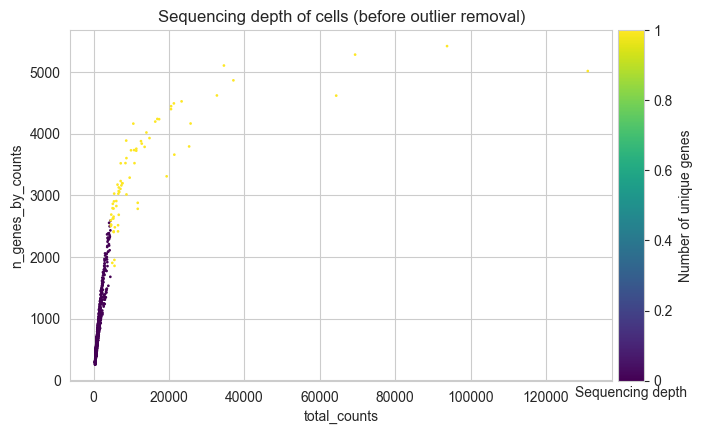

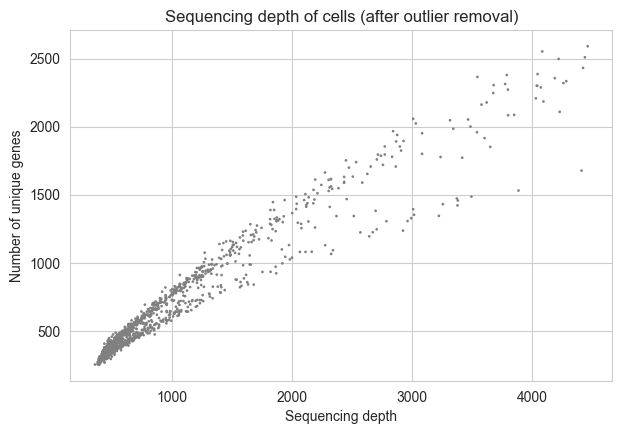

In [8]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization


In [9]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
sc.pp.log1p(data_gene)
data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

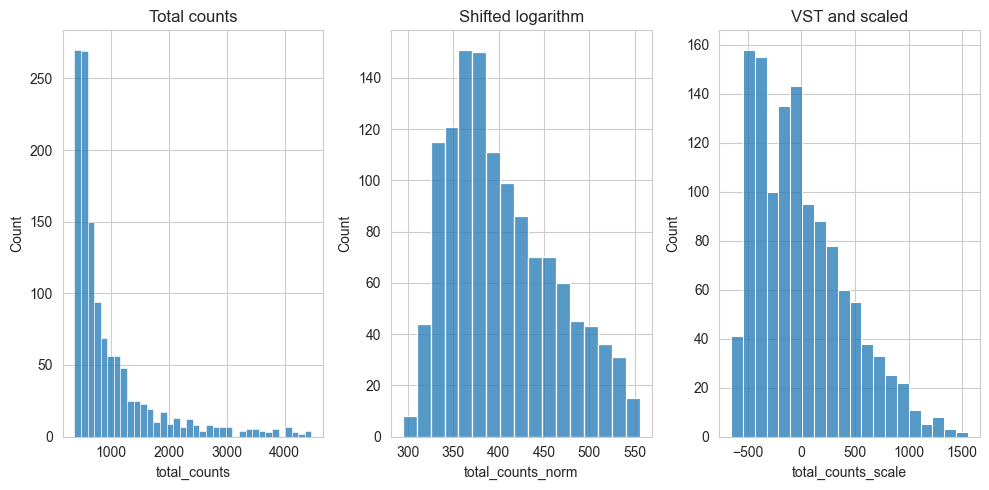

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

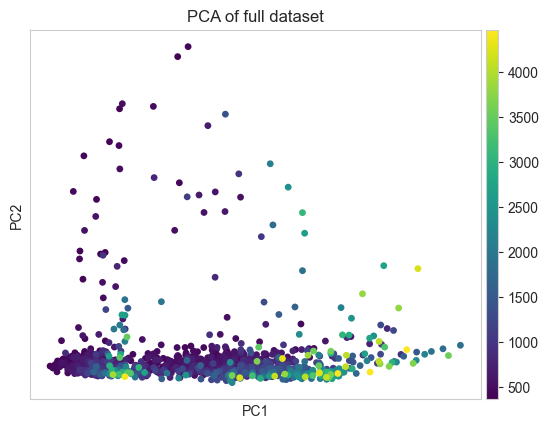

In [11]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

### Neighborhood embedding and UMAP

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


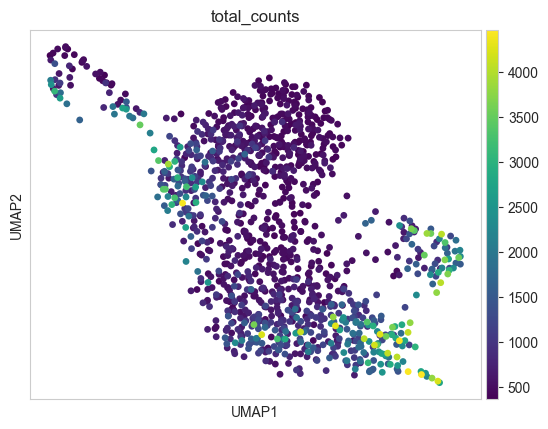

In [12]:
sc.pp.neighbors(data_gene, n_neighbors=10, n_pcs=40)
sc.tl.umap(data_gene)
sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

### clustering

In [13]:
res_min = 0.05
res_max = 0.55
res_step = 0.05
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

for res in resolutions:
    sc.tl.leiden(data_gene, resolution=res, key_added=f"leiden_res_{res}")

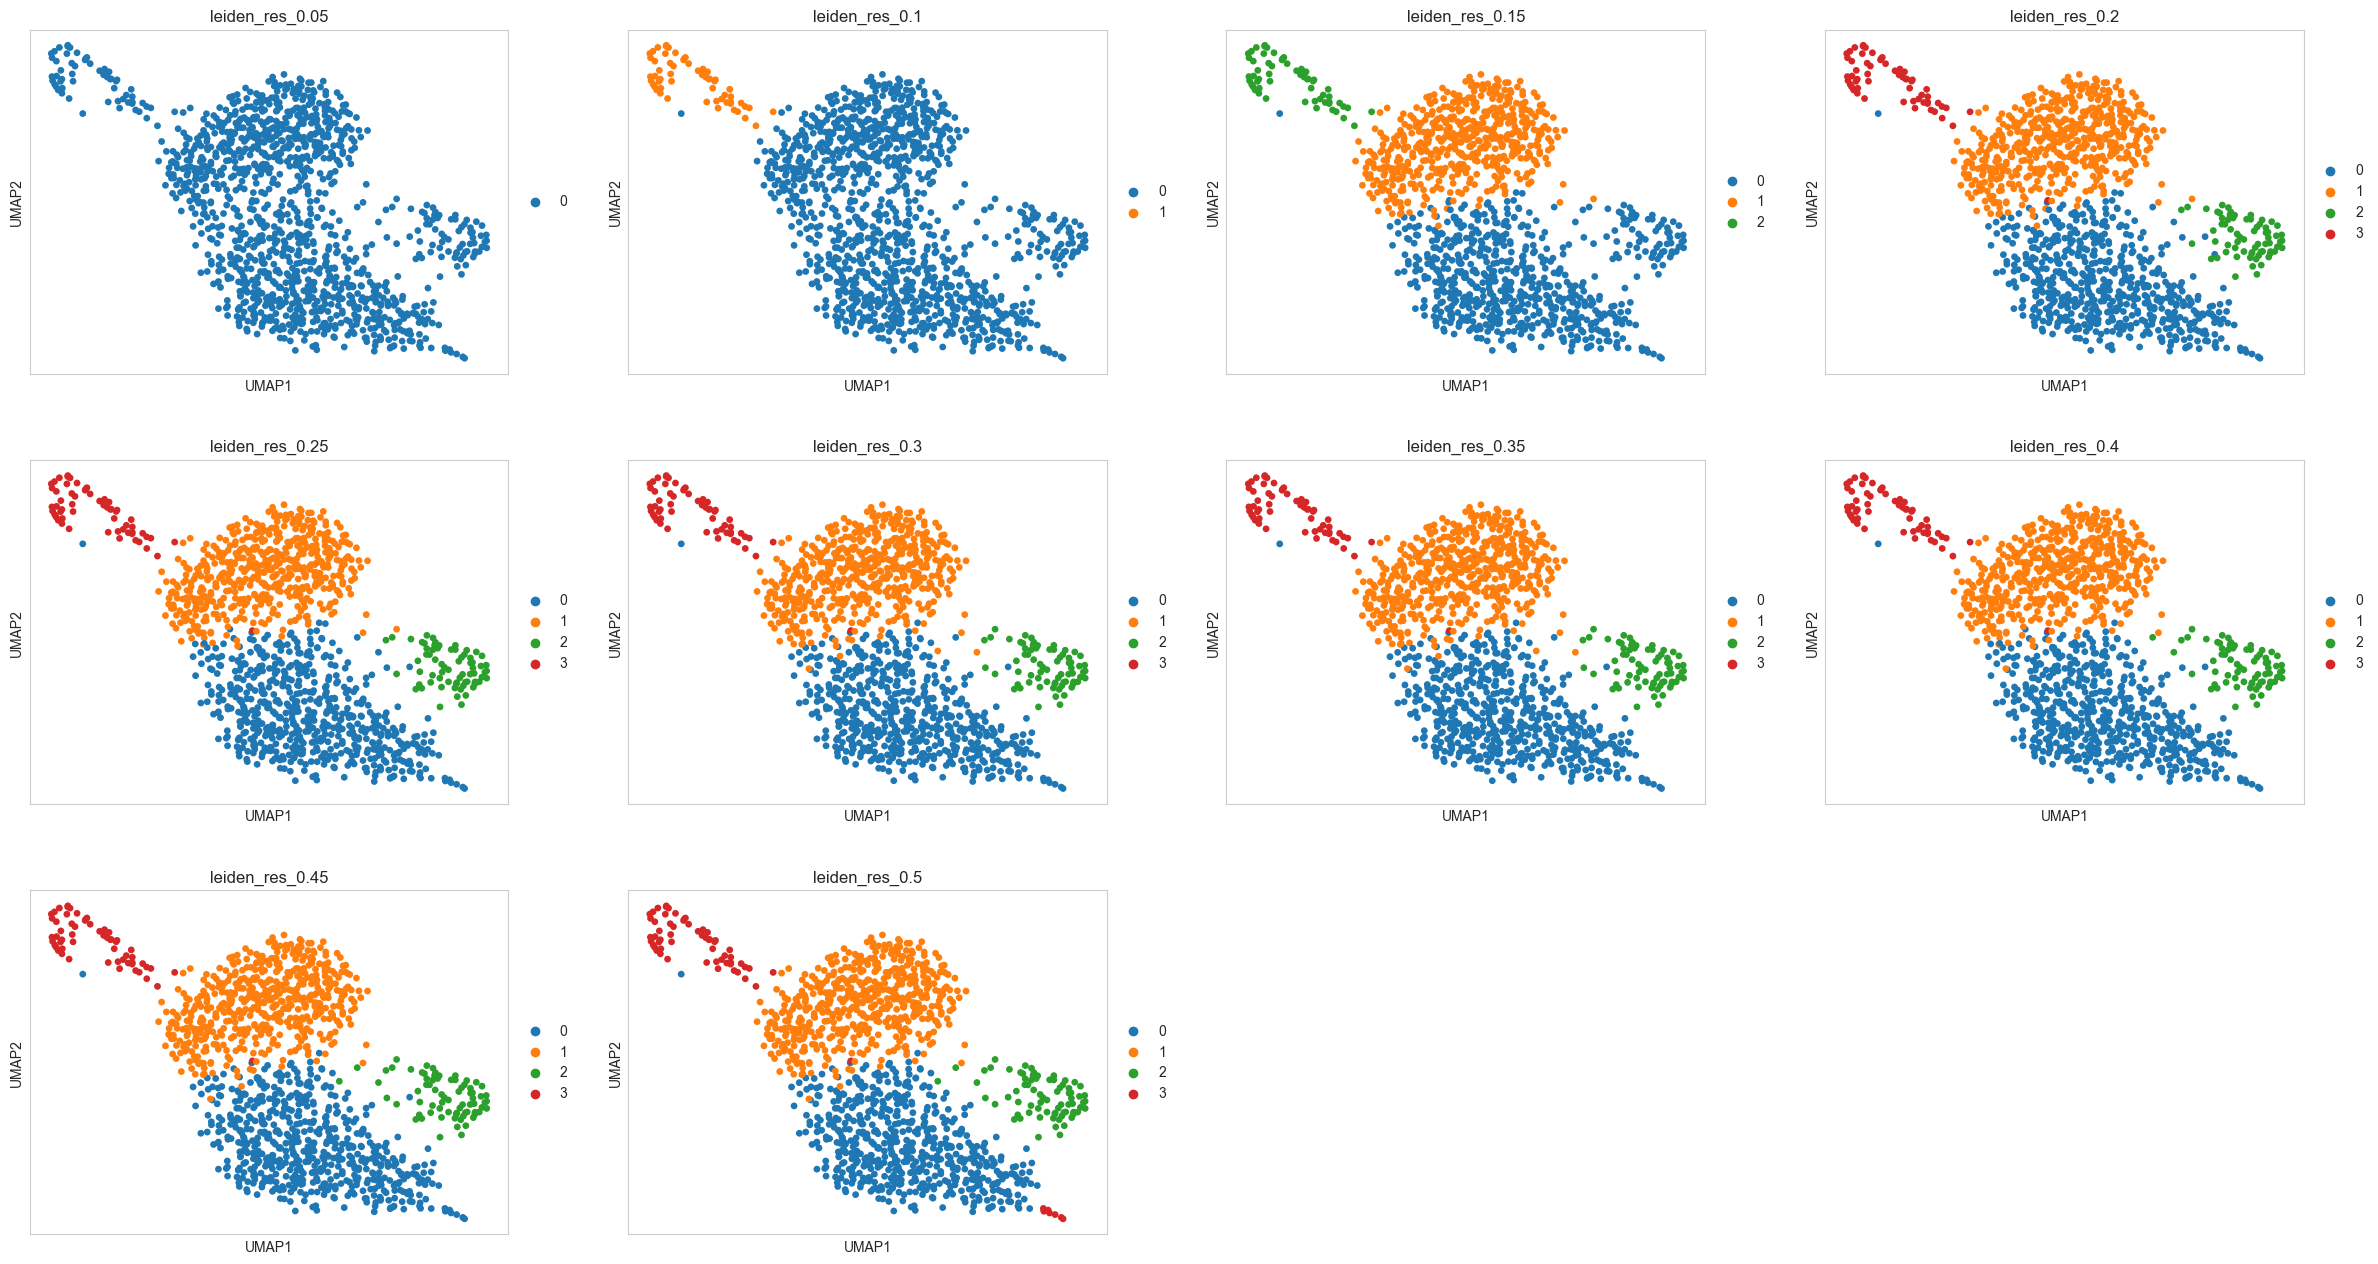

In [14]:
sc.pl.umap(data_gene, color=[f"leiden_res_{res}" for res in resolutions])


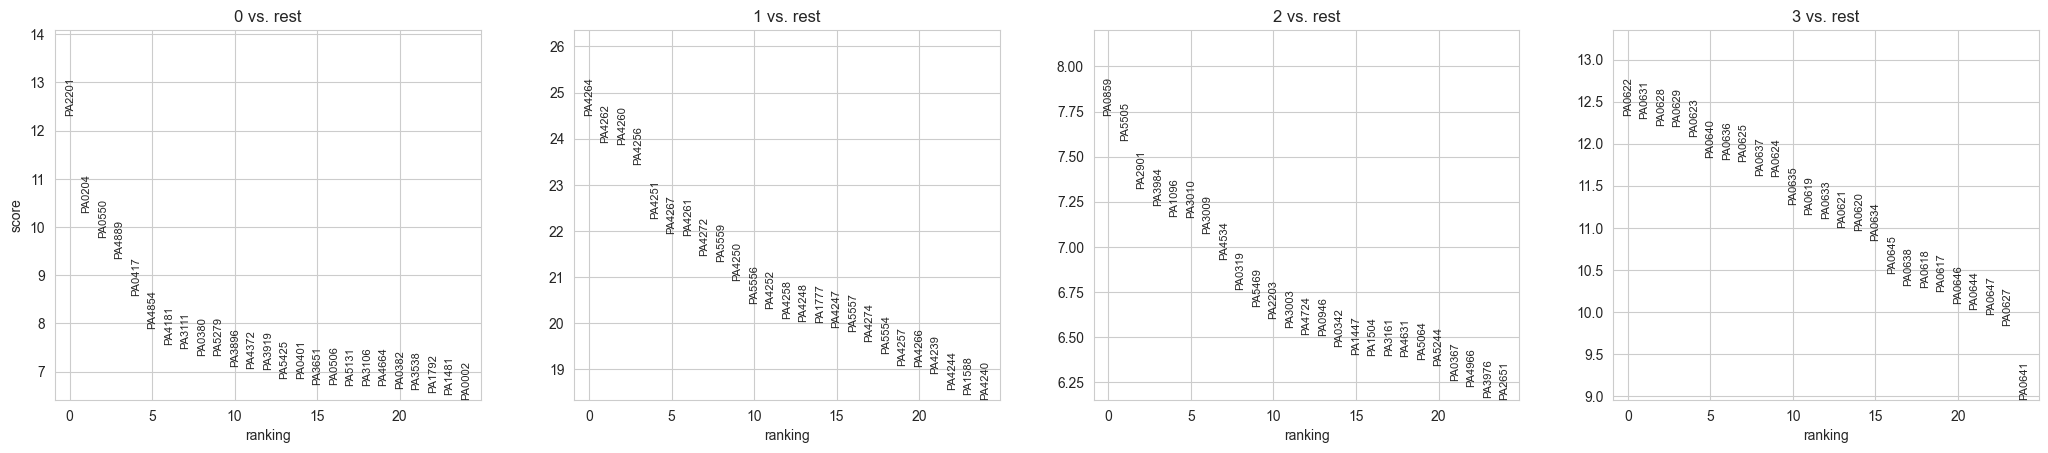

In [15]:
sc.tl.rank_genes_groups(data_gene, 'leiden_res_0.25', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [16]:
data_gene.write(data_path + "/filtered_data_maxpool_standard'.h5ad")
